In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import os


In [16]:
IMG_HEIGHT, IMG_WIDTH = 160, 160
BATCH_SIZE = 64  # Larger batch reduces steps per epoch
EPOCHS = 4


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [18]:
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze pre-trained layers


In [19]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=60,        # REDUCED from full (≈195)
    validation_steps=20,       # Adjustable
    callbacks=[early_stop]
)


Epoch 1/4
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5318 - loss: 1.5547 - val_accuracy: 0.9332 - val_loss: 0.2901
Epoch 2/4


c:\Users\Arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 770ms/step - accuracy: 0.9049 - loss: 0.3209 - val_accuracy: 0.9588 - val_loss: 0.1835
Epoch 3/4
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9157 - loss: 0.2733 - val_accuracy: 0.9689 - val_loss: 0.1207
Epoch 4/4
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 778ms/step - accuracy: 0.9455 - loss: 0.1723 - val_accuracy: 0.9762 - val_loss: 0.1090


In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9681 - loss: 0.1133
Test Accuracy: 97.58%


In [23]:
model.save('fish_classifier_fast.h5')


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [25]:
# Get predictions
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Ground truth
y_true = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())


50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 747ms/step


In [26]:
print(classification_report(y_true, y_pred, target_names=class_labels))


                                  precision    recall  f1-score   support

                     animal fish       0.99      0.98      0.99       520
                animal fish bass       0.86      0.46      0.60        13
   fish sea_food black_sea_sprat       1.00      0.92      0.95       298
   fish sea_food gilt_head_bream       0.98      0.96      0.97       305
   fish sea_food hourse_mackerel       1.00      0.97      0.98       286
        fish sea_food red_mullet       1.00      0.98      0.99       291
     fish sea_food red_sea_bream       0.96      1.00      0.98       273
          fish sea_food sea_bass       0.94      0.99      0.96       327
            fish sea_food shrimp       0.99      1.00      0.99       289
fish sea_food striped_red_mullet       0.93      0.99      0.96       293
             fish sea_food trout       0.99      0.99      0.99       292

                        accuracy                           0.98      3187
                       macro avg    

<Figure size 1000x800 with 0 Axes>

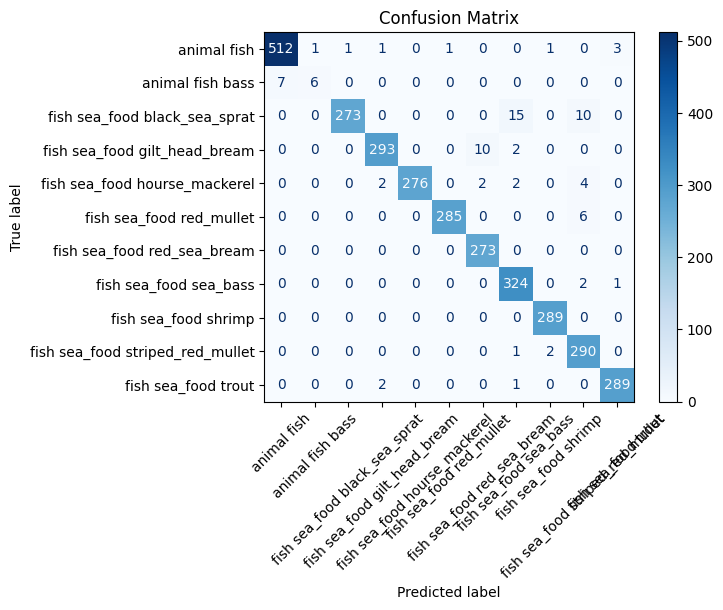

In [27]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


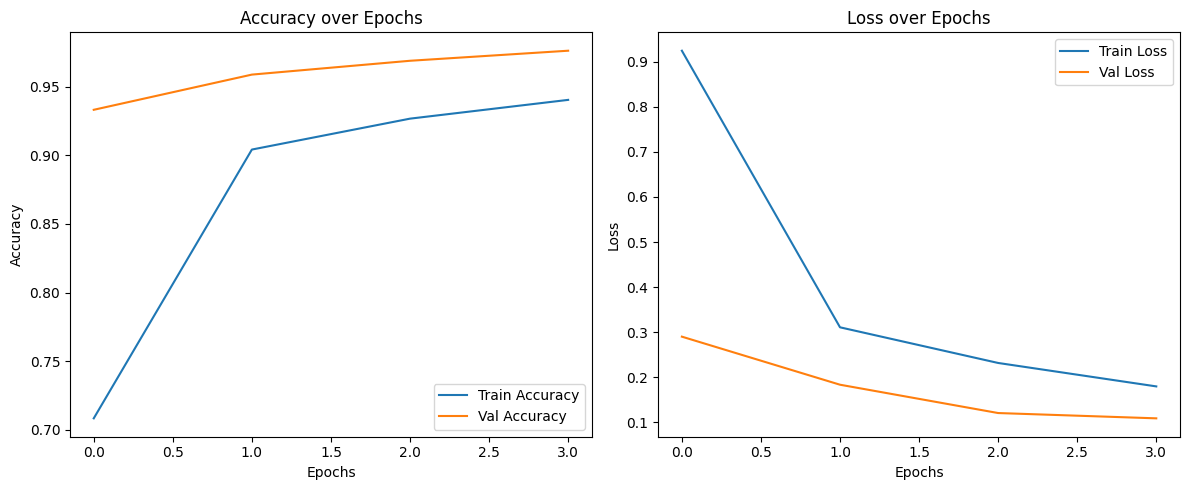

In [28]:
# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()
